# TDOA Location Estimation

Initially we will layout the geometry of the problem. Let the position of the transmitter be denoted $(x, y)$ and that of the $i$th reciever be $(x_{i}, y_{i})$.

<IPython.core.display.Javascript object>


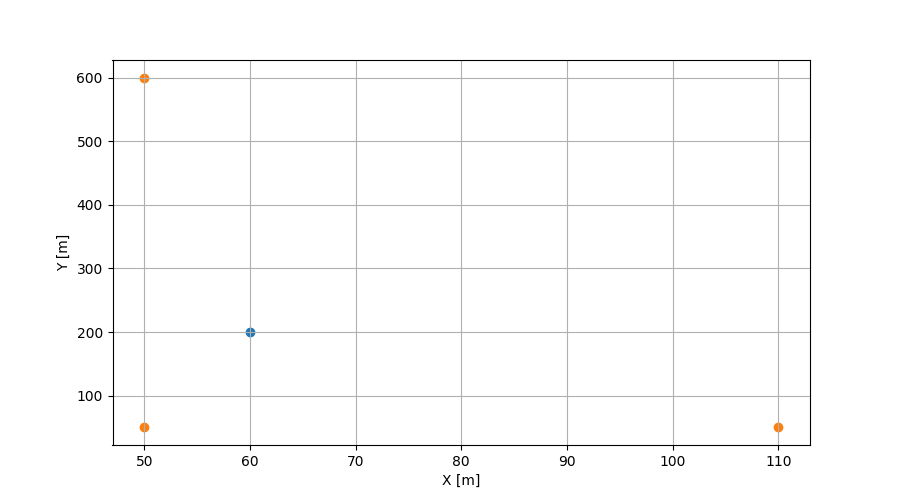

In [61]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# TX Co-ordinates (m)
tx = np.array([60, 200])

# RX Co-ordinates (m)
rx1 = np.array([50, 50])
rx2 = np.array([110, 50])
rx3 = np.array([50, 600])

# Plot Geometry
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(tx))
ax1.scatter(*zip(*(rx1,rx2,rx3)))

# Labels
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.show()

Next lets calculate the time of flight of the signal between the transmitter and each of the recievers. 

In [62]:
import pandas as pd
from numpy import linalg as LA

# Distances (m)
d1 = LA.norm(tx-rx1)
d2 = LA.norm(tx-rx2)
d3 = LA.norm(tx-rx3)

# Time of Flight (s)
t1 = d1/(3e8)
t2 = d2/(3e8)
t3 = d3/(3e8)

# Time Difference of Arrival (s)
t2_1 = t2 - t1
t3_1 = t3 - t1

# Tabulate Data
data = [[d1,d2,d3], [t1*1e9,t2*1e9,t3*1e9], [0,t2_1*1e9,t3_1*1e9]]
df = pd.DataFrame(np.transpose(data), ['RX1', 'RX2', 'RX3'], ['Distance (m)','TOF (ns)', 'TDOA (ns)'])
df.round(2)

,Distance (m),TOF (ns),TDOA (ns)
RX1,150.33,501.11,0.00
RX2,158.11,527.05,25.94
RX3,400.12,1333.75,832.64


Now we can attempt to compute a position estimate. We will use a method proposed in this paper which is commonly reffered to as 'Chan's Method'. https://ieeexplore.ieee.org/document/301830

In [63]:
from numpy.linalg import inv

# Reciever Co-ordinates
X1 = rx1[0]
Y1 = rx1[1]
K1 = np.power(X1, 2) + np.power(Y1, 2)

X2 = rx2[0]
Y2 = rx2[1]
K2 = np.power(X2, 2) + np.power(Y2, 2)

X3 = rx3[0]
Y3 = rx3[1]
K3 = np.power(X3, 2) + np.power(Y3, 2)

# Relative Distances
X2_1 = X2-X1
Y2_1 = Y2-Y1
X3_1 = X3-X1
Y3_1 = Y3-Y1
A = np.array([[X2_1, Y2_1],[X3_1, Y3_1]])

# Range Difference
R2_1 = t2_1*3e8
R3_1 = t3_1*3e8

# Define b vector
b = np.array([[R2_1],[R3_1]])

# Define c vector
c = 0.5*np.array([[R2_1-K2+K1],[R3_1-K3+K1]])

# Define d Vector = -A^(-1)*b
d = -np.matmul(inv(A), b)

# Define e Vector = = -A^(-1)*c
e = -np.matmul(inv(A), c)

# Now lets generate the coefficients of the quadratic used to solve for R1
coeff_a = (np.power(d[0],2)+np.power(d[1],2)-1)
coeff_b = 2*(d[0]*e[0] + d[1]*e[1] - d[0]*X1 - d[1]*Y1)
coeff_c = K1 + np.power(e[0], 2) + np.power(e[1], 2) - 2*X1*e[0] - 2*Y1*e[1]

# Solve for R1
coeff = np.array([coeff_a[0], coeff_b[0], coeff_c[0]])
R1 = np.roots(coeff)

# Now we have R1 we can find the position vector x.
x = R1[1]*d + e
print('x =', x[0], 'y =', x[1])

x = [55.42409153] y = [238.93119182]


Lets plot the position estimate along side the original layout and calculate the error in the estimate.

<IPython.core.display.Javascript object>


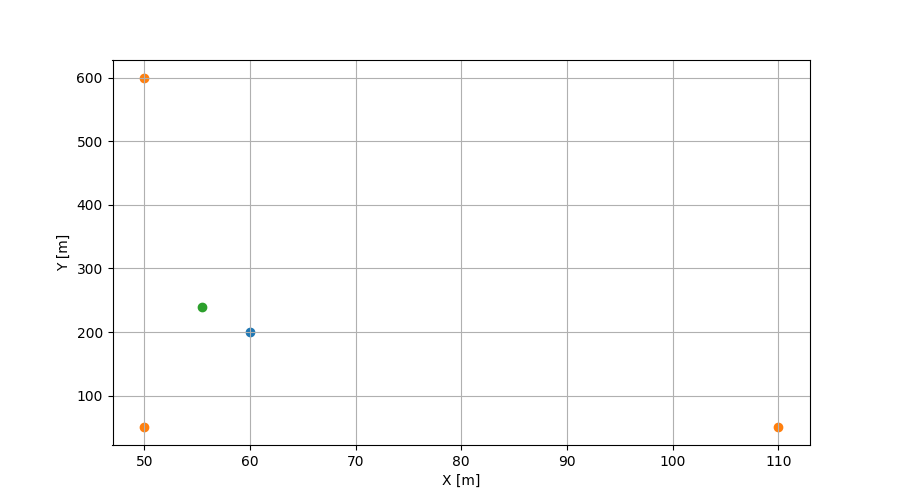

In [64]:
# Plot Geometry
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(tx))
ax1.scatter(*zip(*(rx1,rx2,rx3)))
ax1.scatter(*zip(x))

# Labels
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.show()

In [69]:
# Calculate Absolute Error
x_error = tx[0] - x[0]
y_error = tx[1] - x[1]
abs_error = np.power((np.power(x_error,2)+np.power(y_error,2)),0.5)
print('Error: X =', x_error, 'Y =', y_error, 'Total =', abs_error)

Error: X = [4.57590847] Y = [-38.93119182] Total = [39.19919177]
